In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img,img_to_array

In [2]:
imgs_path = "datathon/"
img_width, img_height = 224, 224
files = [imgs_path + x for x in os.listdir(imgs_path) if x.endswith((".jpg", ".png"))]
print("Total number of images in dataset:",len(files))

Total number of images in dataset: 977


In [3]:
from oml.const import CKPT_SAVE_ROOT as CKPT_DIR, MOCK_DATASET_PATH as DATA_DIR
from oml.models import ViTExtractor
from oml.registry.transforms import get_transforms_for_pretrained

model = ViTExtractor.from_pretrained("vits16_inshop")
transforms, im_reader = get_transforms_for_pretrained("vits16_inshop")

https://oml.daloroserver.com/download/checkpoints/inshop/vits16_inshop_a76b85.ckpt
Checkpoint is already here.
Prefix <model.model.> was removed from the state dict.


In [4]:
features_imgs = []
for filename in files:
    img = im_reader(filename)  
    img_tensor = transforms(img)
    features = model(img_tensor.unsqueeze(0))
    features = features.detach().numpy()
    features_imgs.append(features)
products_features = np.vstack(features_imgs)
products = pd.DataFrame(products_features, index = files)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

cosSimilarities = cosine_similarity(products)
cos_similarities_df = pd.DataFrame(cosSimilarities, index = files, columns = files)
cos_similarities_df.head(10)
def getID(product_path):
    index = product_path.rfind('_')
    index = product_path.rfind('_', 0, index)
    return product_path[:index]

In [6]:
def retrieve_most_similar_products(given_img, cos_similarities_df, nb_closest_images):
    print("-----------------------------------------------------------------------")
    product_name = getID(given_img)
    print("original product:", product_name)
    
    original = load_img(given_img, target_size=(img_width, img_height))
    plt.imshow(original)
    plt.show()
    print("-----------------------------------------------------------------------")
    print("most similar products:")
    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+100].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+100]
    showed_products = []
    showed_products.append(product_name)
    i = 0
    while(len(showed_products) != nb_closest_images + 1):
        name = getID(closest_imgs[i])
        if name in showed_products:
            i+=1
            continue
        if os.path.exists(name + "_image_1.jpg"):
            filename = name + "_image_1.jpg"
        elif os.path.exists(name + "_image_1.png"):
            filename = name + "_image_1.png"
        else:
            filename = closest_imgs[i]
        original = load_img(filename, target_size=(img_width, img_height))
        plt.imshow(original)
        plt.show()
        print("name: ", name)
        print("similarity score : ",closest_imgs_scores.iloc[i])
        i+=1
        showed_products.append(name)

-----------------------------------------------------------------------
original product: datathon/futurenatural_shoes


-----------------------------------------------------------------------
most similar products:


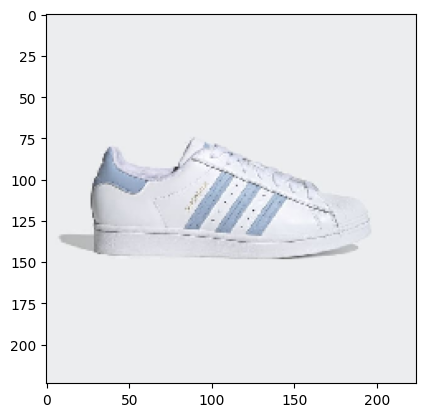

name:  datathon/superstar_shoes
similarity score :  0.96493214


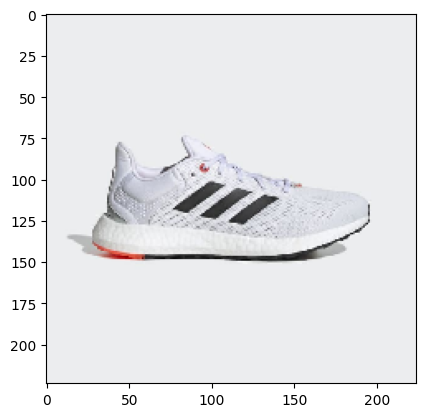

name:  datathon/pureboost_21_shoes
similarity score :  0.9624239


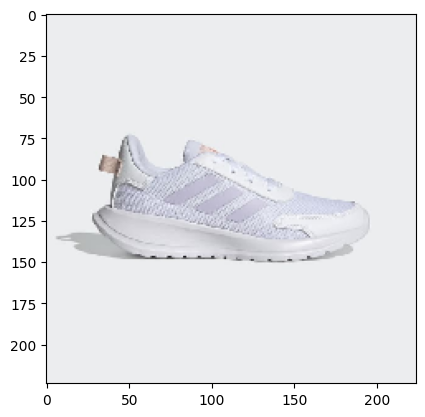

name:  datathon/tensor_run_shoes
similarity score :  0.9617327


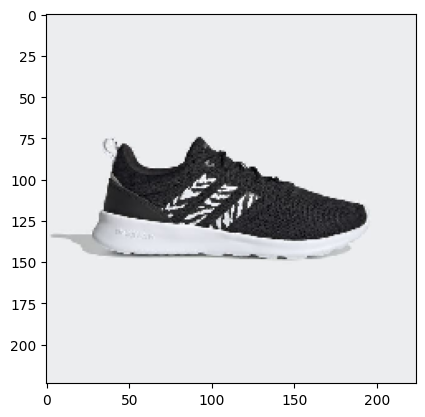

name:  datathon/qt_racer_2.0_shoes
similarity score :  0.9614262


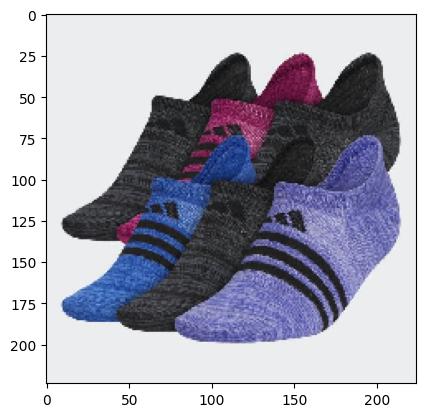

name:  datathon/superlite_super-no-show_socks_6_pairs
similarity score :  0.9613776


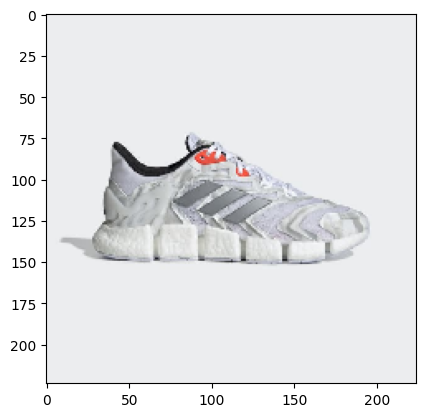

name:  datathon/climacool_vento_shoes
similarity score :  0.96119153


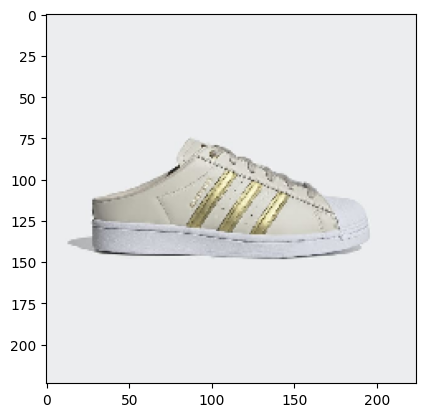

name:  datathon/superstar_mules
similarity score :  0.96087813


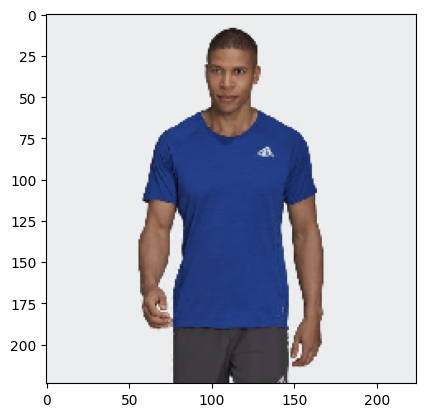

name:  datathon/runner_tee
similarity score :  0.96078193


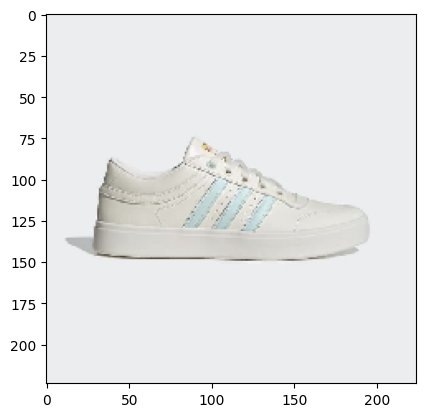

name:  datathon/bryony_shoes
similarity score :  0.96022594


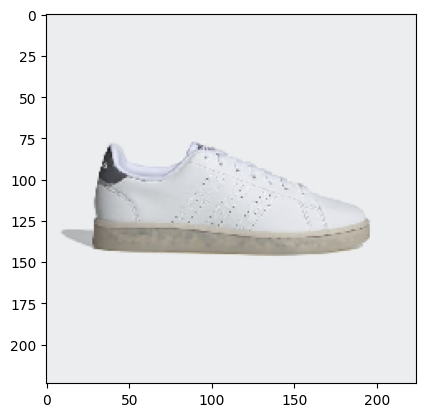

name:  datathon/advantage_eco_shoes
similarity score :  0.96014774


In [7]:
retrieve_most_similar_products(files[47], cos_similarities_df, 10)

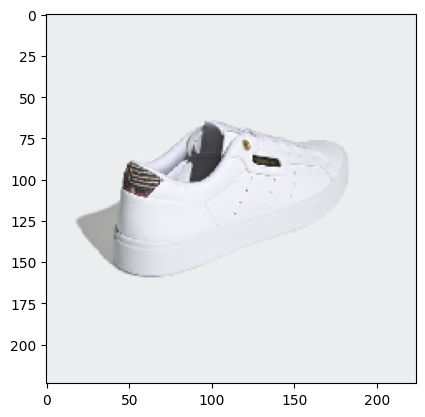

name:  datathon/adidas_sleek_shoes


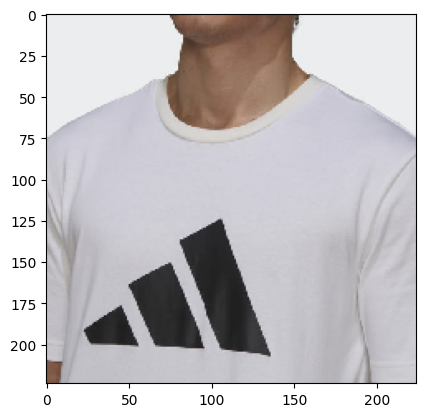

name:  datathon/adidas_sportswear_future_icons_logo_graphic_tee


name:  datathon/adicolor_track_pants


In [33]:
item1 = 'datathon/adidas_sleek_shoes_image_5.jpg'
item2 = 'datathon/adidas_sportswear_future_icons_logo_graphic_tee_image_7.jpg'
item3 = 'datathon/adicolor_track_pants_image_3.jpg'
items = [item1, item2, item3]
for item in items:
    name = getID(item)
    original = load_img(item, target_size=(img_width, img_height))
    plt.imshow(original)
    plt.show()
    print("name: ", name)

In [34]:
from sklearn import linear_model

scores = np.zeros(products_features.shape[0])
indices = [products.index.get_loc(idx) for idx in items]
scores[indices] = 1
clf = linear_model.Ridge(alpha=0.01, fit_intercept  = True)
clf.fit(products_features, scores)
w = clf.coef_
b = clf.intercept_
ratings = products_features.dot(w) + b
top_indices = np.argsort(ratings)[::-1][:100]

/Users/pianokill/miniconda3/envs/datathon/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.02039e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [35]:
items = [getID(item) for item in items]
if getID(files[top_indices[0]]) in items:
    print("HI")

HI


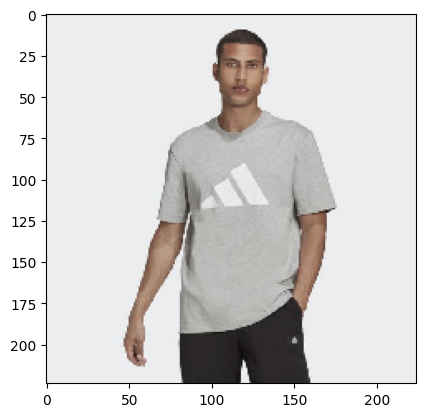

name:  datathon/adidas_sportswear_future_icons_logo_graphic_tee


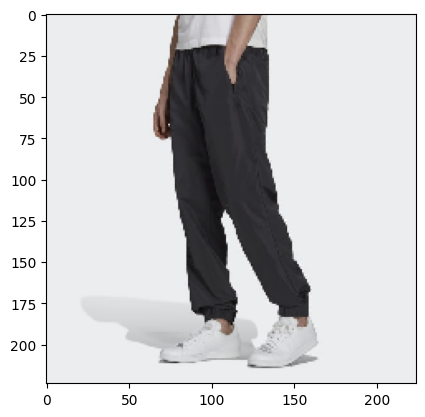

name:  datathon/adicolor_track_pants


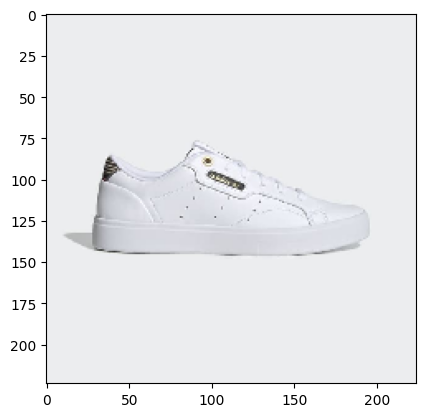

name:  datathon/adidas_sleek_shoes
datathon/adicolor_track_pants
datathon/adidas_sportswear_future_icons_logo_graphic_tee


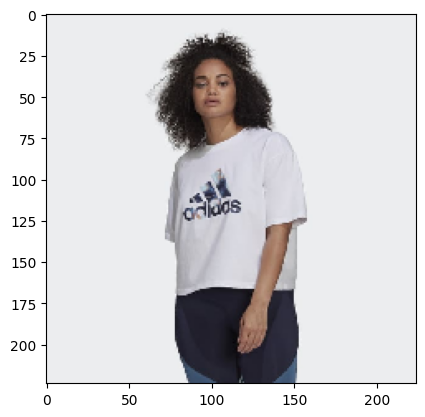

name:  datathon/adidas_x_zoe_saldana_crop_logo_tee_(plus_size)
datathon/adicolor_track_pants


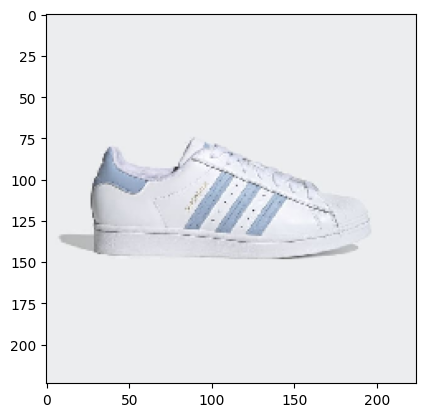

name:  datathon/superstar_shoes


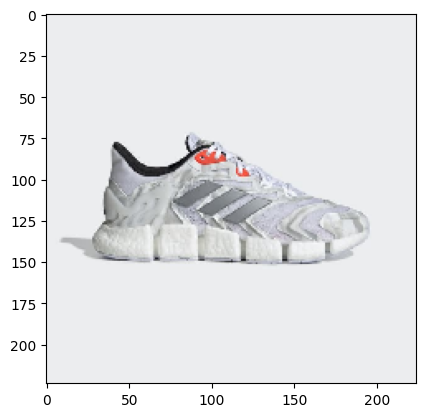

name:  datathon/climacool_vento_shoes


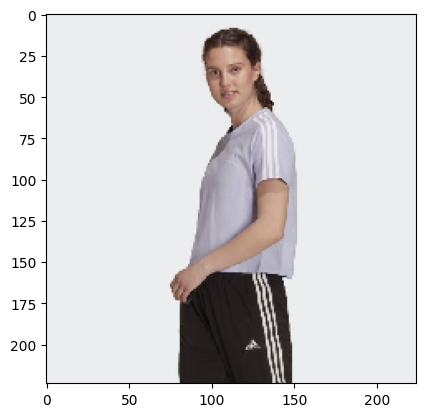

name:  datathon/essentials_loose_3-stripes_cropped_tee


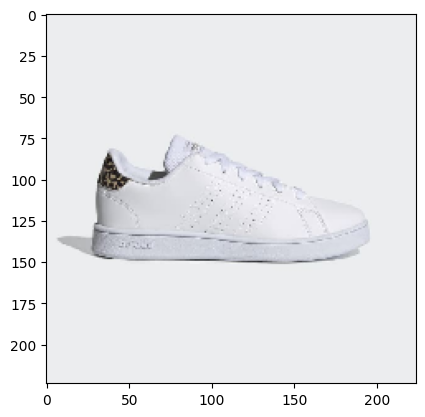

name:  datathon/advantage_shoes
datathon/adicolor_track_pants


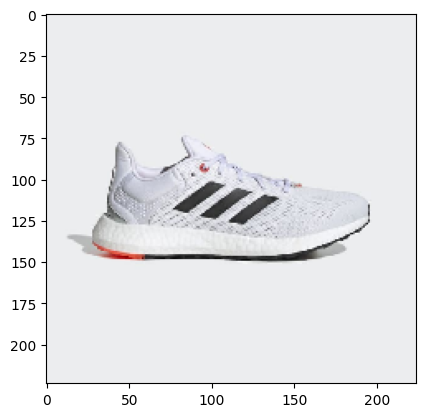

name:  datathon/pureboost_21_shoes


name:  datathon/marathon_3-stripes_jacket
datathon/adidas_sleek_shoes


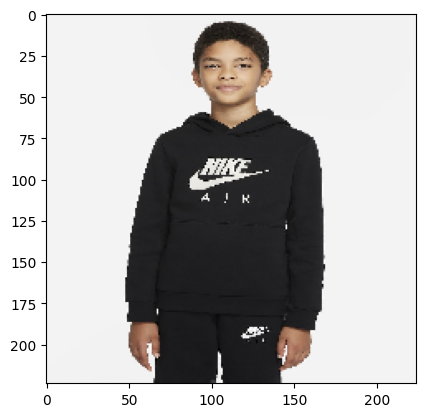

name:  datathon/nike_air


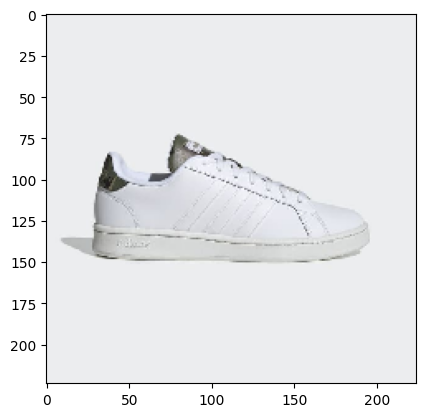

name:  datathon/grand_court_shoes


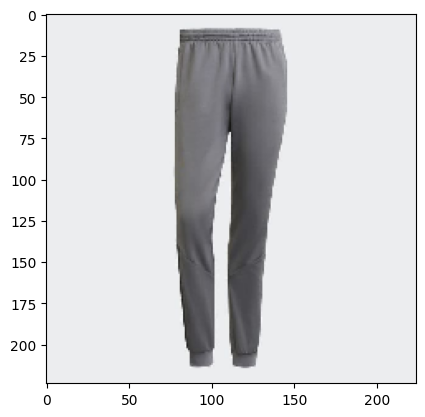

name:  datathon/adidas_sprt_colorblock_track_pants


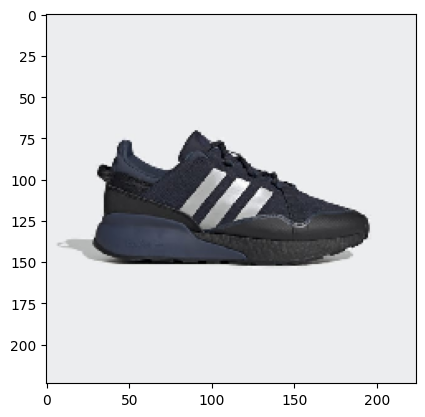

name:  datathon/zx_2k_boost_pure_shoes


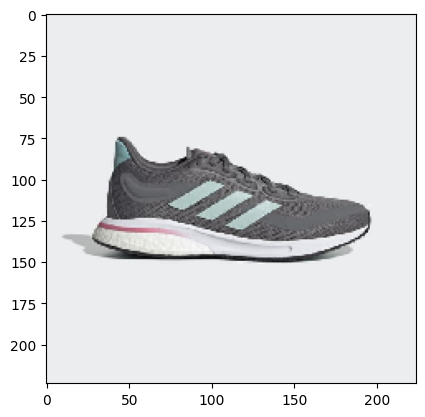

name:  datathon/supernova_shoes


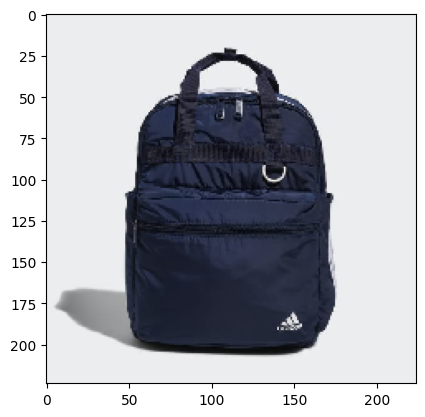

name:  datathon/essentials_backpack


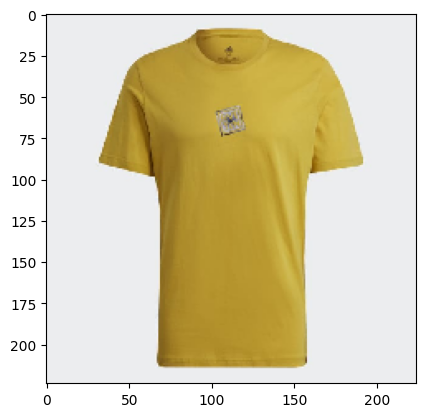

name:  datathon/five_ten_heritage_logo_tee


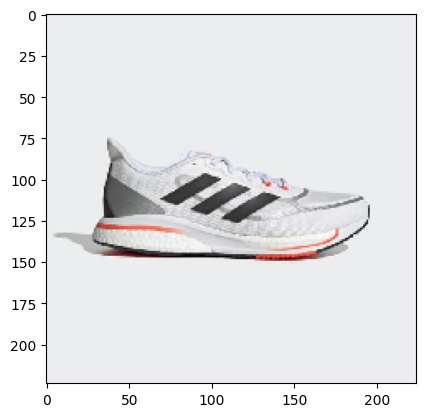

name:  datathon/supernova+_shoes


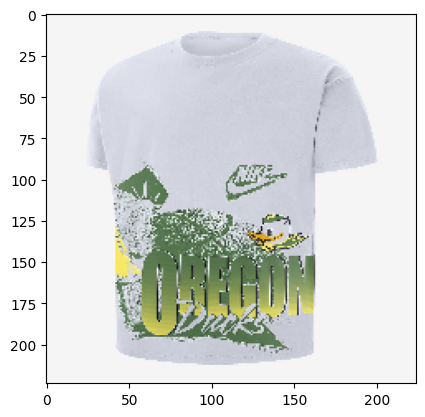

name:  datathon/nike_college_(oregon)


name:  datathon/mlb_arizona_diamondbacks_city_connect


In [31]:
nb_closest_images = 20
i = 0
items = [getID(item) for item in items]
while(len(items) - 3 != nb_closest_images):
    name = getID(files[top_indices[i]])
    if name in items:
        print(name)
        i+=1
        continue
    if os.path.exists(name + "_image_1.jpg"):
        filename = name + "_image_1.jpg"
    elif os.path.exists(name + "_image_1.png"):
        filename = name + "_image_1.png"
    else:
        filename = files[top_indices[i]]
    original = load_img(filename, target_size=(img_width, img_height))
    plt.imshow(original)
    plt.show()
    print("name: ", name)
    i+=1
    items.append(name)

In [19]:
item1 = "datathon/adidas_sleek_shoes_image_5.jpg"
item2 = "datathon/adidas_sportswear_future_icons_logo_graphic_tee_image_7.jpg"
item3 = "datathon/adicolor_track_pants_image_3.jpg"
items = [item1, item2, item3]
indices = [products.index.get_loc(idx) for idx in items]
X = np.zeros(products_features.shape[1])
for index in indices:
    X = products_features[index] + X
X = X/len(indices)
items = [getID(item) for item in items]

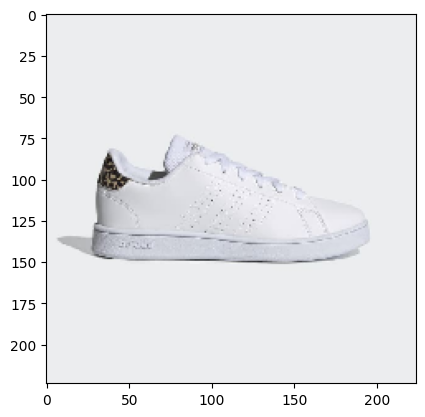

name:  datathon/advantage_shoes


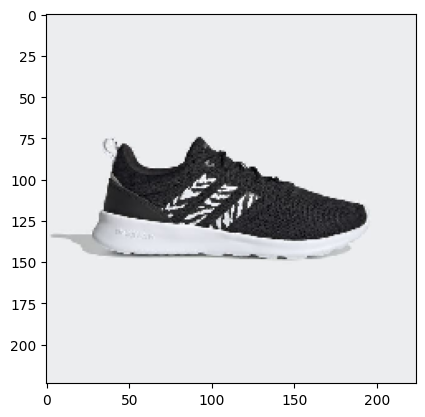

name:  datathon/qt_racer_2.0_shoes


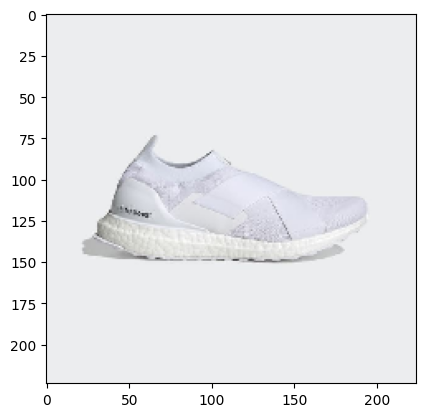

name:  datathon/ultraboost_slip-on_dna_shoes


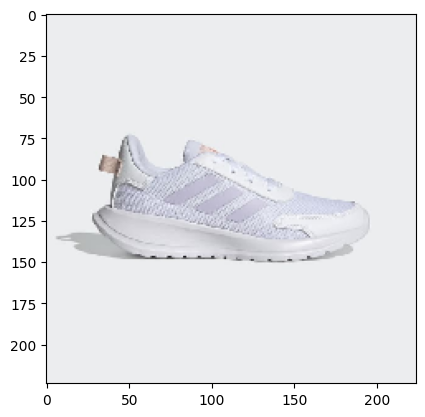

name:  datathon/tensor_run_shoes


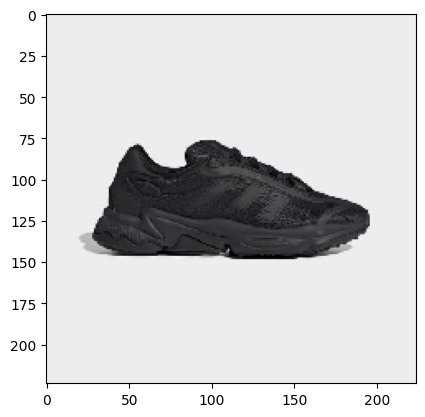

name:  datathon/ozweego_pure_shoes


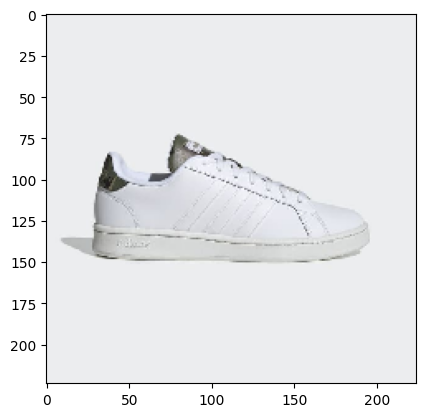

name:  datathon/grand_court_shoes


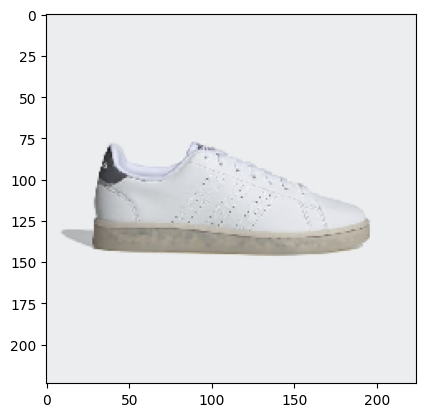

name:  datathon/advantage_eco_shoes


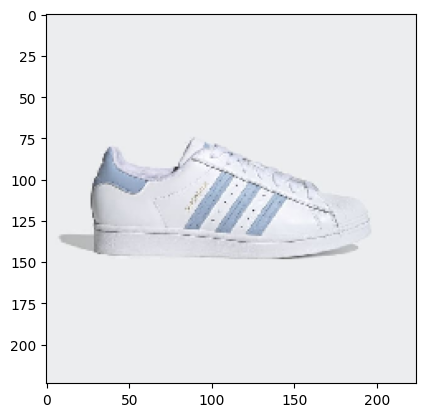

name:  datathon/superstar_shoes


name:  datathon/swift_run_x_shoes


name:  datathon/marvel_superhero_racer_tr_2.0_shoes


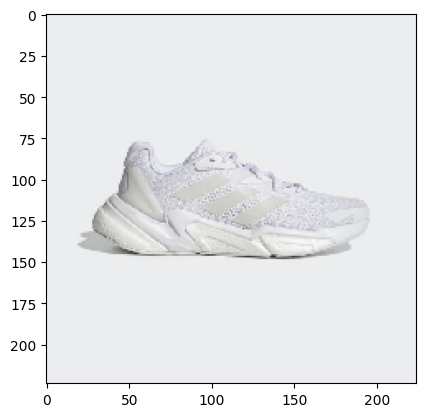

name:  datathon/x9000l3_shoes


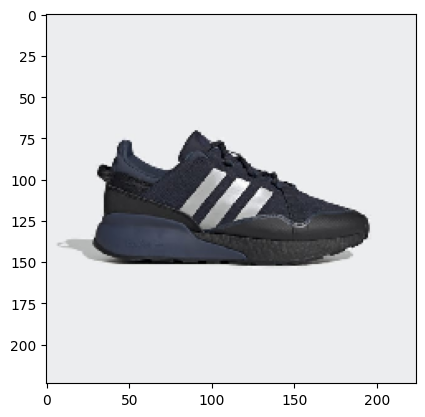

name:  datathon/zx_2k_boost_pure_shoes


name:  datathon/adilette_lite_slides


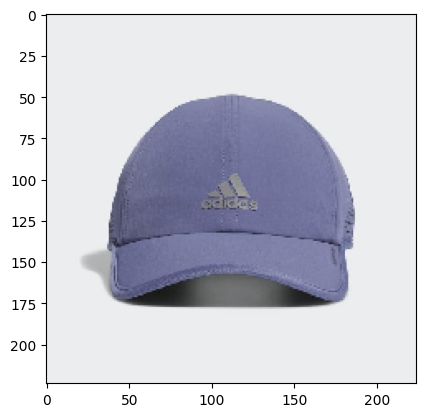

name:  datathon/superlite_hat


name:  datathon/lite_racer_adapt_4.0_shoes


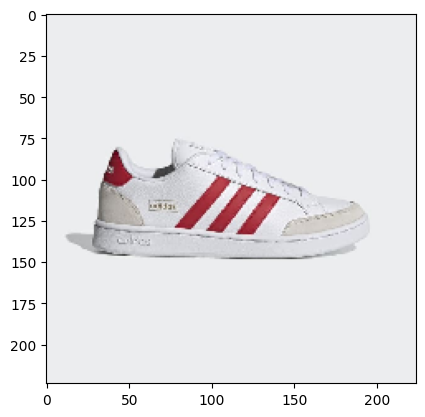

name:  datathon/grand_court_se_shoes


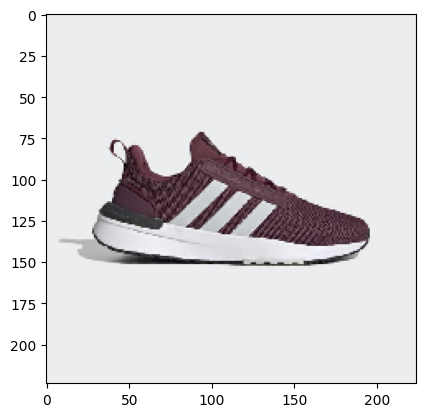

name:  datathon/racer_tr21_shoes


name:  datathon/predator_freak.3_indoor_shoes


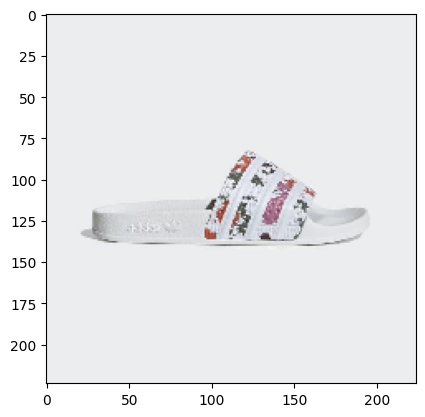

name:  datathon/adilette_slides


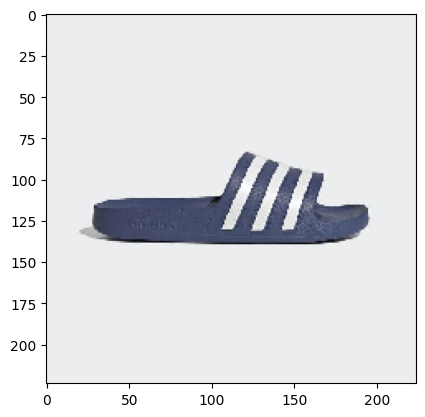

name:  datathon/adilette_aqua_slides


name:  datathon/court_tourino_shoes


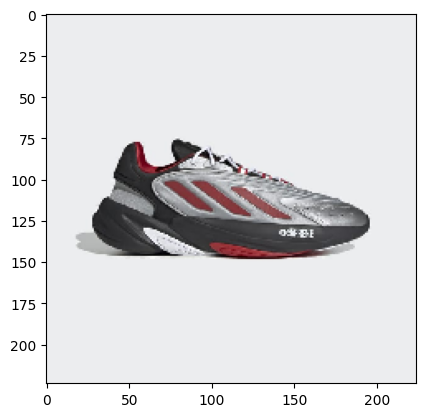

name:  datathon/ozelia_shoes


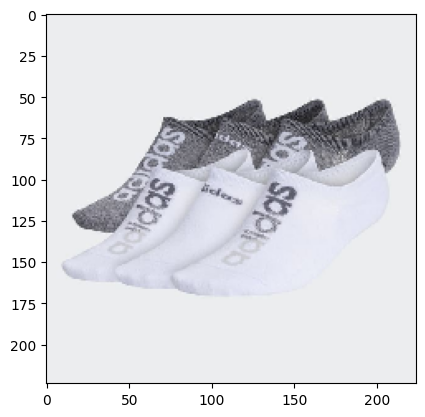

name:  datathon/linear_superlite_super-no-show_socks_6_pairs


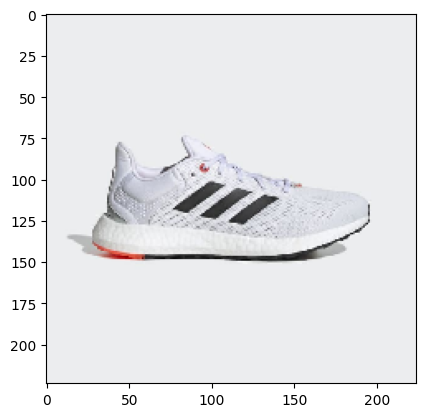

name:  datathon/pureboost_21_shoes


In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(products)

knn_model = NearestNeighbors(n_neighbors=50)  # Replace K with the desired number of neighbors
knn_model.fit(scaled_features)

scaled_query_vector = scaler.transform([X])
distances, indices = knn_model.kneighbors(scaled_query_vector)
nearest_neighbors_ids = products.index[indices.flatten()].tolist()
for item in nearest_neighbors_ids:
    name = getID(item)
    if name in items:
        continue
    if os.path.exists(name + "_image_1.jpg"):
        filename = name + "_image_1.jpg"
    elif os.path.exists(name + "_image_1.png"):
        filename = name + "_image_1.png"
    else:
        filename = files[top_indices[i]]
    original = load_img(filename, target_size=(img_width, img_height))
    plt.imshow(original)
    plt.show()
    print("name: ", name)
    items.append(name)